In [ ]:
# Import required libraries for scATAC-seq metacell analysis
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

np.random.seed(1966)


In [ ]:
def compute_SEACells(ad, div=75, nwaypointeigs=10,
                     min_iter=10, max_iter=50):
    """
    Compute SEACells metacells from single-cell ATAC-seq data.
    
    Parameters:
    - ad: AnnData object with scATAC-seq data
    - div: Divisor for determining number of metacells (n_cells / div)
    - nwaypointeigs: Number of eigenvalues for metacell initialization
    - min_iter: Minimum iterations for convergence
    - max_iter: Maximum iterations allowed
    
    Returns:
    - Tuple: (annotated AnnData, hard assignment AnnData, soft assignment AnnData, SEACells model)
    """
    # Plot cell clusters for reference
    sc.pl.scatter(ad, basis='umap', color='Clusters', frameon=False)
    
    # Core parameters
    n_metacells = ad.shape[0] // div  # Rule of thumb: n_cells/75
    kernel_key = 'X_svd'  # LSI embeddings for ATAC data
    
    # Additional parameters
    n_waypoint_eigs = nwaypointeigs  # Eigenvalues for metacell initialization
    
    # Build SEACells model
    model = SEACells.core.SEACells(ad, build_kernel_on=kernel_key, n_SEACells=n_metacells,
                                   n_waypoint_eigs=n_waypoint_eigs, convergence_epsilon=1e-5)
    
    model.construct_kernel_matrix()
    M = model.kernel_matrix
    
    sns.clustermap(M.toarray()[:500,:500])
    
    # Initialize archetypes
    model.initialize_archetypes()
    
    # Plot initialization across phenotypic space
    SEACells.plot.plot_initialization(ad, model)
    
    # Fit SEACells model
    model.fit(min_iter=min_iter, max_iter=max_iter)
    
    # Check for model convergence
    model.plot_convergence()
    
    # Access SEACell hard assignments
    model.get_hard_assignments().head()
    
    # Plot distribution of non-trivial assignments per cell
    plt.figure(figsize=(3,2))
    sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
    plt.title('Non-trivial (> 0.1) assignments per cell')
    plt.xlabel('# Non-trivial SEACell Assignments')
    plt.ylabel('# Cells')
    plt.show()
    
    # Plot strength of top 5 assignments
    plt.figure(figsize=(3,2))
    b = np.partition(model.A_.T, -5)    
    sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
    plt.title('Strength of top 5 strongest assignments')
    plt.xlabel('$n^{th}$ strongest assignment')
    plt.show()

    # Prepare raw data layer for summarization
    raw_ad = sc.AnnData(ad.X)
    raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
    ad.raw = raw_ad
    
    # Summarize by SEACell (hard assignments)
    seacell_hard_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
    seacell_hard_ad

    # Summarize by soft SEACell assignments
    seacell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='Clusters',
                                                                summarize_layer='raw', minimum_weight=0.05)
    seacell_soft_ad
    
    seacell_soft_ad.obs.head()

    # Plot SEACells over UMAP
    SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)
    SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)
    
    # Plot SEACell size distribution
    SEACells.plot.plot_SEACell_sizes(ad, bins=5)
    
    # Compute and plot purity of SEACell for given cell types
    seacell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'Clusters')
    
    plt.figure(figsize=(4,4))
    sns.boxplot(data=seacell_purity, y='Clusters_purity')
    plt.title('Celltype Purity')
    sns.despine()
    plt.show()
    plt.close()
    
    seacell_purity.head()
    
    return ad, seacell_hard_ad, seacell_soft_ad, model

In [ ]:
def read_input_ad_normalization_later(control_path, pimq_path):
    """
    Read and aggregate SEACells from Control and PIMQ samples.
    
    Generates metacell-level summaries including peak counts, LSI coordinates,
    UMAP projections, and gene activity scores.
    
    Parameters:
    - control_path: Path to Control sample h5ad file
    - pimq_path: Path to PIMQ sample h5ad file
    
    Returns:
    - List: [control_metacell_ad, pimq_metacell_ad]
    """
    
    # Process Control sample
    ctrl_ad = sc.read(control_path)
    seacells_label = "SEACell"

    # Filter to metacells with >1 cell
    metacells = ctrl_ad.obs[seacells_label].astype(str).unique()
    metacells = metacells[ctrl_ad.obs[seacells_label].value_counts()[metacells] > 1]
    print("Generating Metacell matrices...")
    print("ATAC")
        
    ctrl_meta_ad = SEACells.core.summarize_by_SEACell(ctrl_ad, SEACells_label=seacells_label, summarize_layer="X")
    print(ctrl_meta_ad)
    
    # Reorder SEACells with sample suffix
    ctrl_meta_ad = ctrl_meta_ad[['SEACell-' + str(i) + '-0' for i in range(ctrl_meta_ad.shape[0])], :]

    # Aggregate LSI embeddings by metacell
    lsi_coords = pd.DataFrame(ctrl_ad.obsm["X_svd"], index=ctrl_ad.obs_names)
    lsi_meta = lsi_coords.groupby(ctrl_ad.obs[seacells_label]).mean()
    lsi_meta = lsi_meta.reindex(ctrl_meta_ad.obs_names)
    ctrl_meta_ad.obsm["X_svd"] = lsi_meta.values

    # Aggregate UMAP coordinates by metacell
    umap_coords = pd.DataFrame(ctrl_ad.obsm['X_umap']).set_index(ctrl_ad.obs_names).join(ctrl_ad.obs["SEACell"])
    umap_coords["SEACell"] = umap_coords["SEACell"].astype("category")
    umap_meta = umap_coords.groupby("SEACell").mean()
    ctrl_meta_ad.obsm['X_umap'] = np.array(umap_meta[[0,1]])

    # Aggregate gene activity scores by metacell
    ctrl_genescores = pd.DataFrame(ctrl_ad.obsm['GeneScores'])
    ctrl_genescores.columns = list(ctrl_ad.uns['GeneScoresColums'])
    ctrl_genescores.index = ctrl_ad.obs_names
    ctrl_genescores = ctrl_genescores.join(ctrl_ad.obs['SEACell']).groupby('SEACell').sum()

    # Store gene scores in metacell object
    ctrl_meta_ad.obsm['GeneScores'] = ctrl_genescores
    ctrl_meta_ad.uns['GeneScoresColumns'] = list(ctrl_meta_ad.obsm['GeneScores'].columns)
    
    ################################
    # Process PIMQ sample
    ################################
    
    pimq_ad = sc.read(pimq_path)
    seacells_label = "SEACell"

    # Filter to metacells with >1 cell
    metacells = pimq_ad.obs[seacells_label].astype(str).unique()
    metacells = metacells[pimq_ad.obs[seacells_label].value_counts()[metacells] > 1]
    print("Generating Metacell matrices...")
    print("ATAC")
    
    pimq_meta_ad = SEACells.core.summarize_by_SEACell(pimq_ad, SEACells_label=seacells_label, summarize_layer="X")
    print(pimq_meta_ad)

    # Reorder SEACells with sample suffix
    pimq_meta_ad = pimq_meta_ad[['SEACell-' + str(i) + '-1' for i in range(pimq_meta_ad.shape[0])], :]

    # Aggregate LSI embeddings by metacell
    lsi_coords = pd.DataFrame(pimq_ad.obsm["X_svd"], index=pimq_ad.obs_names)
    lsi_meta = lsi_coords.groupby(pimq_ad.obs[seacells_label]).mean()
    lsi_meta = lsi_meta.reindex(pimq_meta_ad.obs_names)
    pimq_meta_ad.obsm["X_svd"] = lsi_meta.values

    # Aggregate UMAP coordinates by metacell
    umap_coords = pd.DataFrame(pimq_ad.obsm['X_umap']).set_index(pimq_ad.obs_names).join(pimq_ad.obs["SEACell"])
    umap_coords["SEACell"] = umap_coords["SEACell"].astype("category")
    umap_meta = umap_coords.groupby("SEACell").mean()
    pimq_meta_ad.obsm['X_umap'] = np.array(umap_meta[[0,1]])
    
    # Aggregate gene activity scores by metacell
    pimq_genescores = pd.DataFrame(pimq_ad.obsm['GeneScores'])
    pimq_genescores.columns = list(pimq_ad.uns['GeneScoresColums'])
    pimq_genescores.index = pimq_ad.obs_names
    pimq_genescores = pimq_genescores.join(pimq_ad.obs['SEACell']).groupby('SEACell').sum()

    # Store gene scores in metacell object
    pimq_meta_ad.obsm['GeneScores'] = pimq_genescores
    pimq_meta_ad.uns['GeneScoresColumns'] = list(pimq_meta_ad.obsm['GeneScores'].columns)
    
    return [ctrl_meta_ad, pimq_meta_ad]

# D30 Dataset: SEACells Metacell Construction

In [ ]:
# Define paths for D30 dataset
timepoint = 'D30'
sample_type = 'D30'

input_dir = '../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/'
data_dir = input_dir + 'seacells/SEACells_export/'


In [ ]:
# Load peak accessibility count matrix
from scipy.io import mmread
peak_counts = mmread(data_dir + 'peak_counts/counts.mtx')

# Load cell and peak metadata
cell_names = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peak_info = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)
peak_info.index = peak_info['seqnames'] + ':' + peak_info['start'].astype(str) + '-' + peak_info['end'].astype(str)



In [ ]:
# Build AnnData object with peak accessibility matrix
ad = sc.AnnData(peak_counts.T)
ad.obs_names = cell_names
ad.var_names = peak_info.index
for col in peak_info.columns:
    ad.var[col] = peak_info[col]
ad.X = ad.X.tocsr()

# Load LSI embeddings
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, :].values

# Load cell metadata
cell_metadata = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, :]
for col in cell_metadata.columns:
    ad.obs[col] = cell_metadata[col].values

# Load gene activity scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T

ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

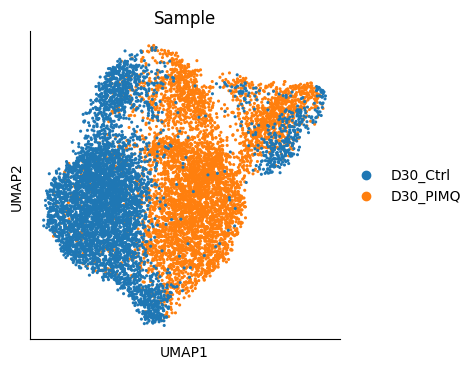

In [ ]:
# Compute neighborhood graph and UMAP on LSI coordinates
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)
sc.pl.umap(ad, color=['Sample'], vmin='p5', vmax='p95', s=20)

In [ ]:
# Split by sample condition
ad_ctrl = ad[ad.obs['Sample'] == sample_type + '_Ctrl']
ad_pimq = ad[ad.obs['Sample'] == sample_type + '_PIMQ']

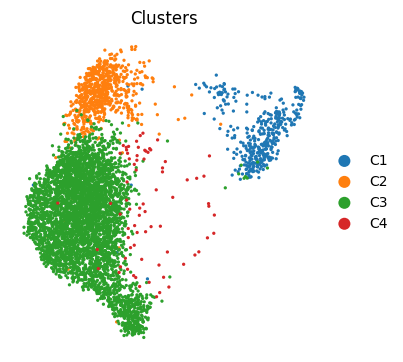

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5403 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/5403 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5403 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 68 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 14/14 [00:00<00:00, 112.05it/s]


Selecting 4 cells from greedy initialization.


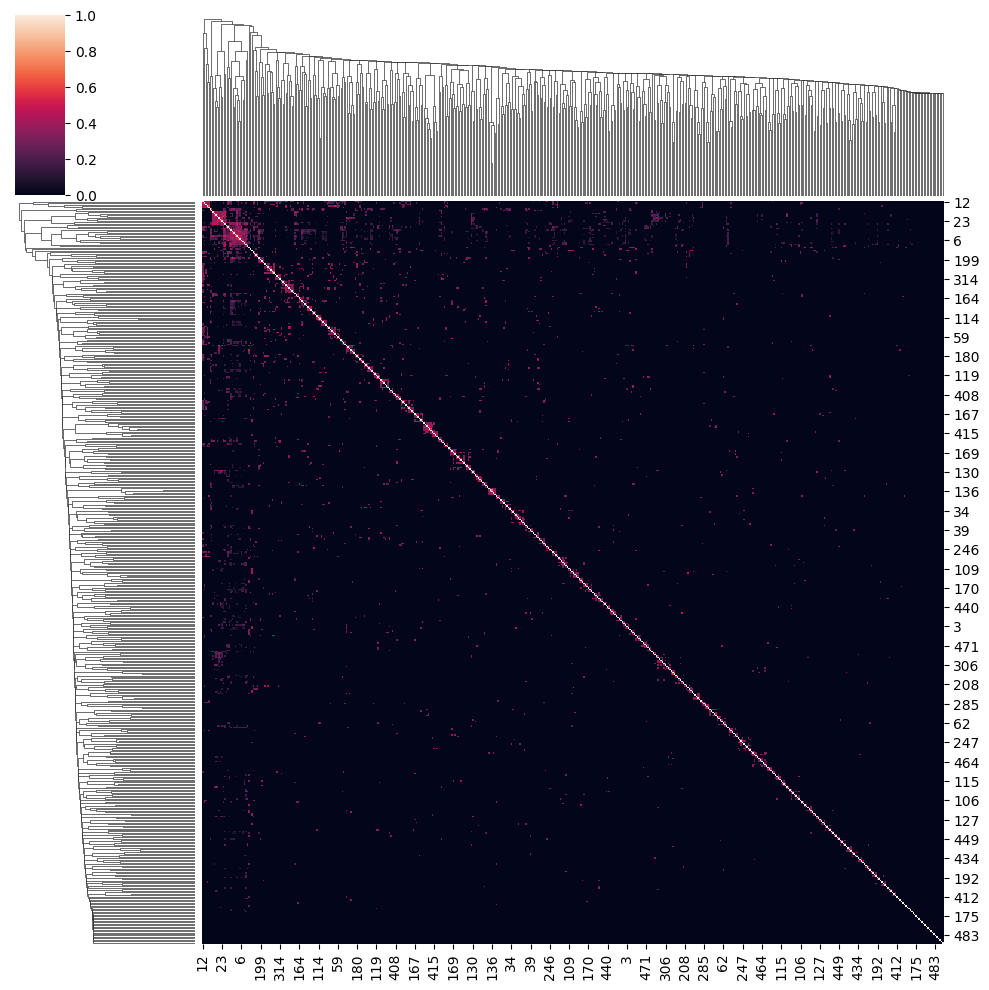

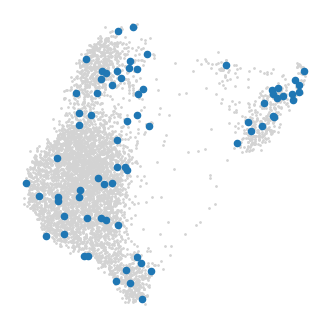

Randomly initialized A matrix.
Setting convergence threshold at 0.00133
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


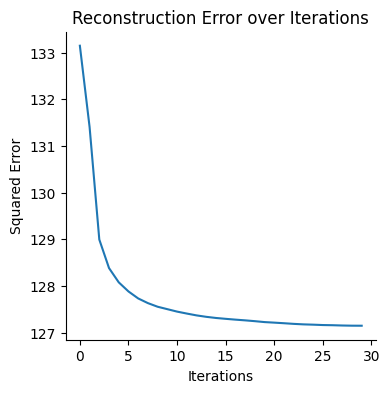

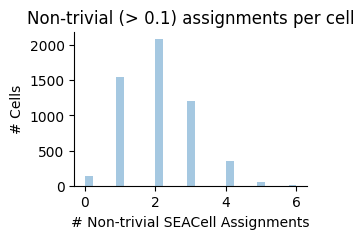

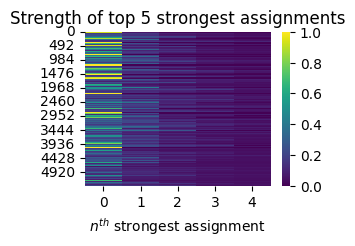

100%|██████████| 72/72 [01:39<00:00,  1.38s/it]


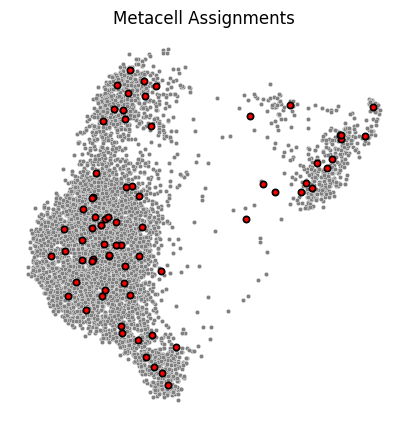

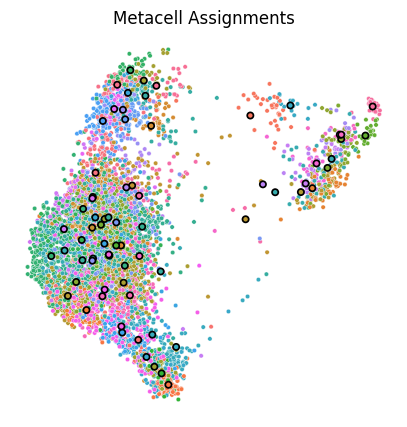

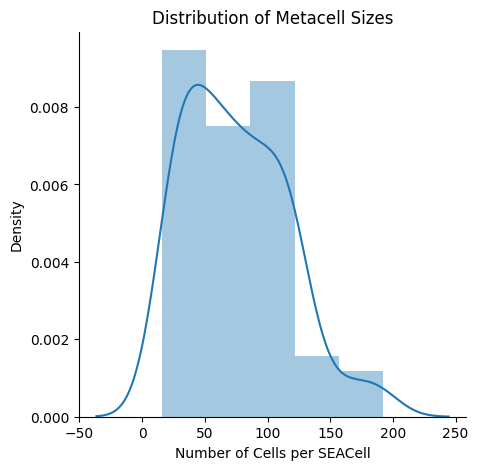

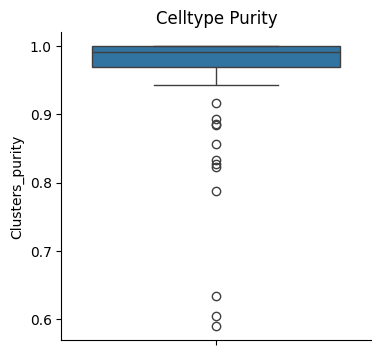

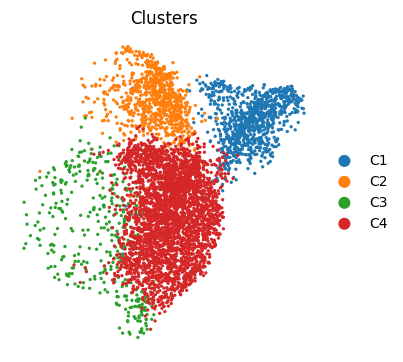

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/5325 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/5325 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/5325 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 58 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 23/23 [00:00<00:00, 129.85it/s]


Selecting 13 cells from greedy initialization.


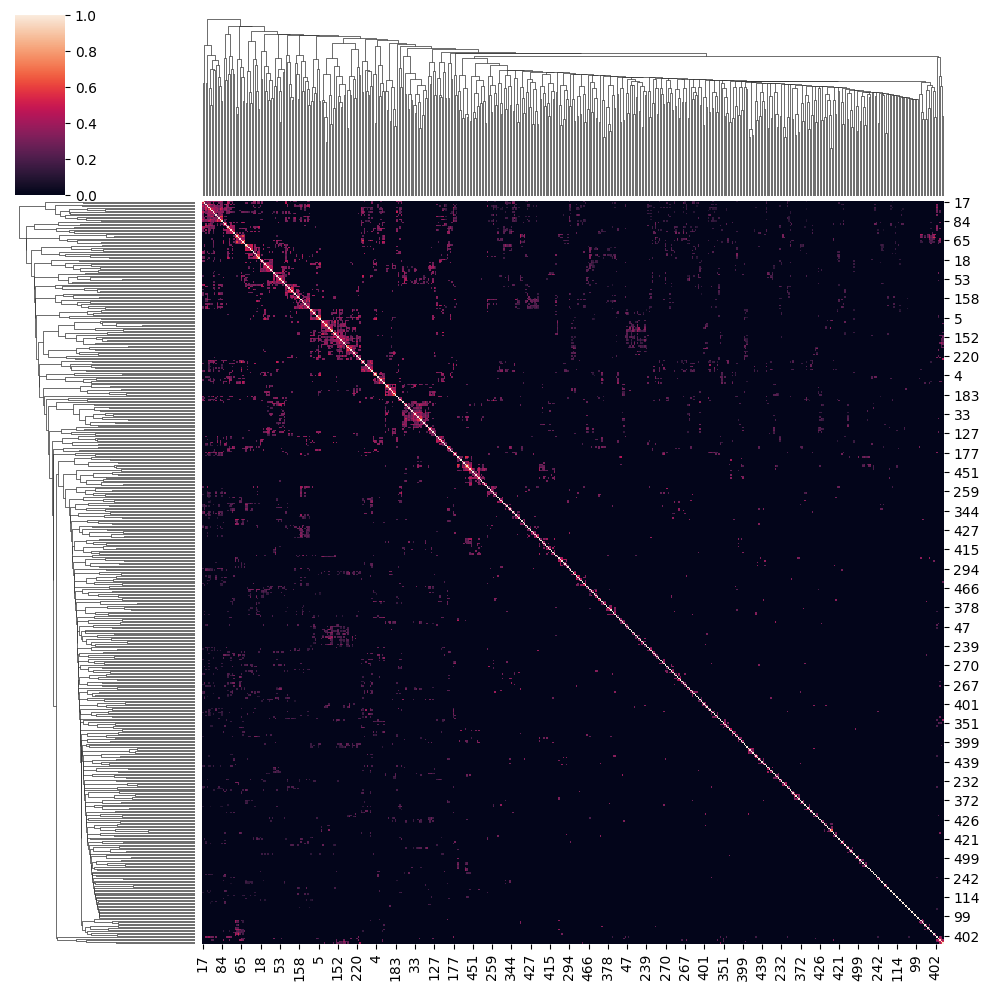

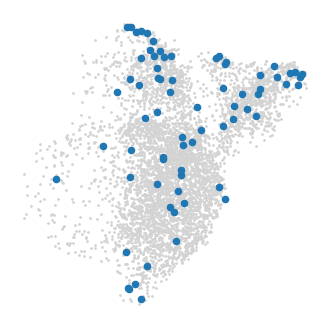

Randomly initialized A matrix.
Setting convergence threshold at 0.00128
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 27 iterations.


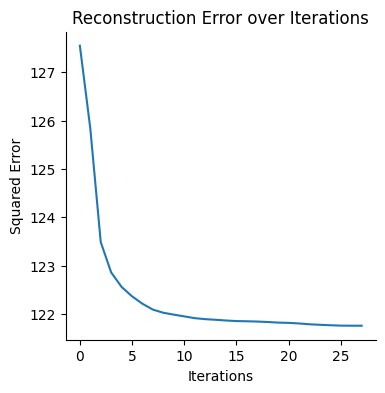

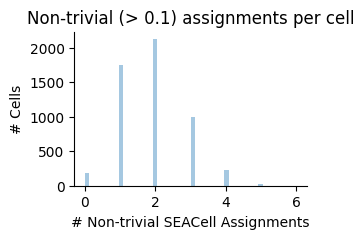

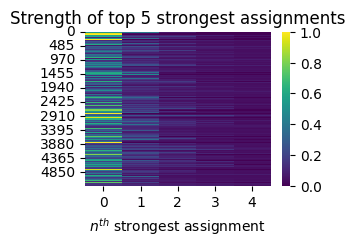

100%|██████████| 71/71 [01:51<00:00,  1.58s/it]


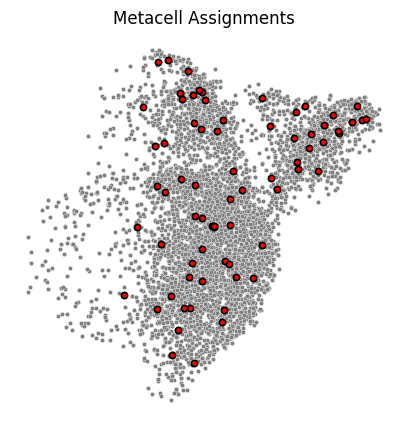

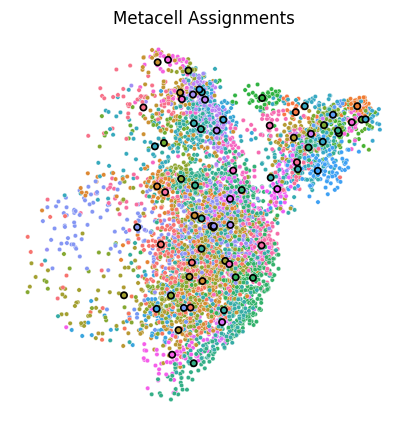

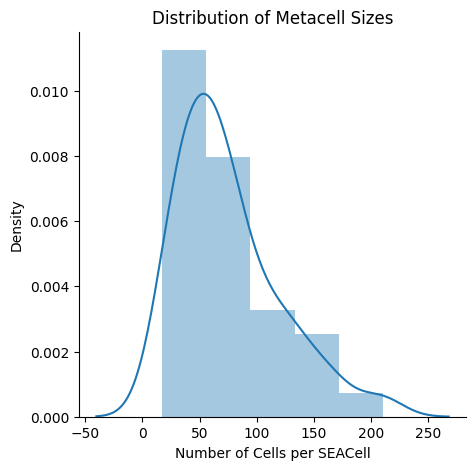

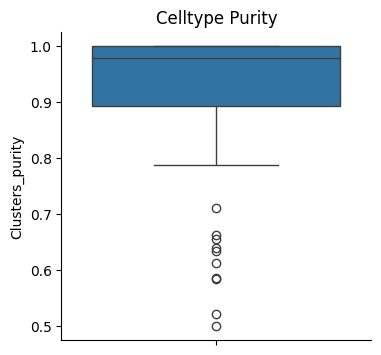

In [ ]:
# Compute SEACells independently for each condition
results_ctrl = compute_SEACells(ad=ad_ctrl, max_iter=500)
results_pimq = compute_SEACells(ad=ad_pimq, max_iter=500)

In [ ]:
# Add sample suffixes to SEACell IDs (-0 for Control, -1 for PIMQ)
results_ctrl[0].obs['SEACell'] = results_ctrl[0].obs['SEACell'] + '-0'
results_pimq[0].obs['SEACell'] = results_pimq[0].obs['SEACell'] + '-1'

# Save individual sample SEACell assignments
results_ctrl[0].write(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
results_pimq[0].write(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')

res_list = [results_ctrl, results_pimq]

# Reload for merging
ad_ctrl = sc.read(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
ad_pimq = sc.read(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')

# Export SEACell assignments to Excel
ad_ctrl.obs['SEACell'].to_frame().to_excel(input_dir + 'seacells/' + 'SEACell_control.xlsx')
ad_pimq.obs['SEACell'].to_frame().to_excel(input_dir + 'seacells/' + 'SEACell_PIMQ.xlsx')

ad_list = [ad_ctrl, ad_pimq]
    
# Compute total fragments per SEACell
n_frags_per_seacell = pd.concat([ad_list[0].obs.groupby(by='SEACell')['nFrags'].sum(),
                                  ad_list[1].obs.groupby(by='SEACell')['nFrags'].sum()])

n_frags_per_seacell.to_csv(input_dir + 'seacells/' + 'nFrags_per_seacell.csv')

# Merge single-cell data from both conditions
ad_merged = anndata.concat([ad_list[0], ad_list[1]], label='batch')
ad_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_ad_concat.h5ad')

# Merge SEACell hard assignments
hard_list = []
for i in range(2):
    suffix = '-' + str(i)
    res_list[i][1].obs = res_list[i][1].obs.rename(index=lambda x: x + suffix)
    hard_list.append(res_list[i][1])
    
seacells_hard_merged = anndata.concat([hard_list[0], hard_list[1]], label='batch')
seacells_hard_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_SEACells_hard_concat.h5ad')

# Merge SEACell soft assignments (cluster purity)
soft_cluster_list = []
for i in range(2):
    suffix = '-' + str(i)
    res_list[i][2].obs = res_list[i][2].obs.rename(index=lambda x: 'SEACell-' + x + suffix)
    soft_cluster_list.append(res_list[i][2])
    
seacells_soft_merged = anndata.concat([soft_cluster_list[0], soft_cluster_list[1]], label='batch')
seacells_soft_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_SEACells_soft_concat.h5ad')


In [ ]:
# Set random seed for reproducibility
np.random.seed(1966)

# Define paths for metacell aggregation
input_dir = '../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/'
timepoint = 'D30'
sample_type = 'D30'

print(input_dir)

ctrl_path = input_dir + 'seacells/' + timepoint + '_Control.h5ad'
pimq_path = input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad'

print(ctrl_path)
print(pimq_path)

../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/
../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/seacells/D30_Control.h5ad
../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/seacells/D30_PIMQ.h5ad


In [ ]:
# Generate metacell-level summaries
ctrl_meta_ad, pimq_meta_ad = read_input_ad_normalization_later(ctrl_path, pimq_path)


Generating Metacell matrices...
ATAC


100%|███████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 31.04it/s]


AnnData object with n_obs × n_vars = 72 × 112211
    layers: 'raw'
Generating Metacell matrices...
ATAC


100%|███████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.72it/s]


AnnData object with n_obs × n_vars = 71 × 112211
    layers: 'raw'


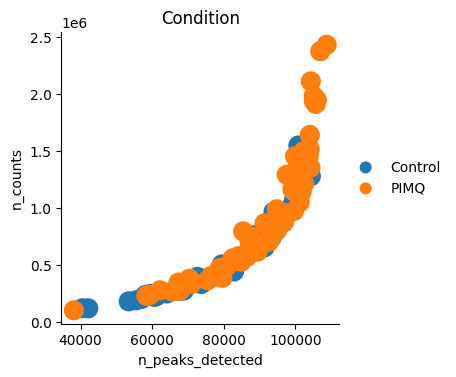

In [ ]:
# Merge Control and PIMQ metacells
ad_meta = sc.concat([ctrl_meta_ad, pimq_meta_ad])

# Add condition labels based on metacell IDs
metacell_ids = list(ad_meta.obs.index)
conditions = ['Control' if mid.endswith('-0') else 'PIMQ' for mid in metacell_ids]
ad_meta.obs['Condition'] = conditions

# Compute QC metrics
ad_meta.obs['n_counts'] = np.ravel(ad_meta.X.sum(axis=1))
ad_meta.obs['n_peaks_detected'] = (ad_meta.X > 0).sum(axis=1)

sc.pl.scatter(ad_meta, x='n_peaks_detected', y='n_counts', color='Condition')


In [10]:
ad_norm

AnnData object with n_obs × n_vars = 143 × 112211
    obs: 'Condition', 'n_counts', 'n_peaks_detected'
    uns: 'Condition_colors'
    obsm: 'X_svd', 'X_umap', 'GeneScores'
    layers: 'raw'

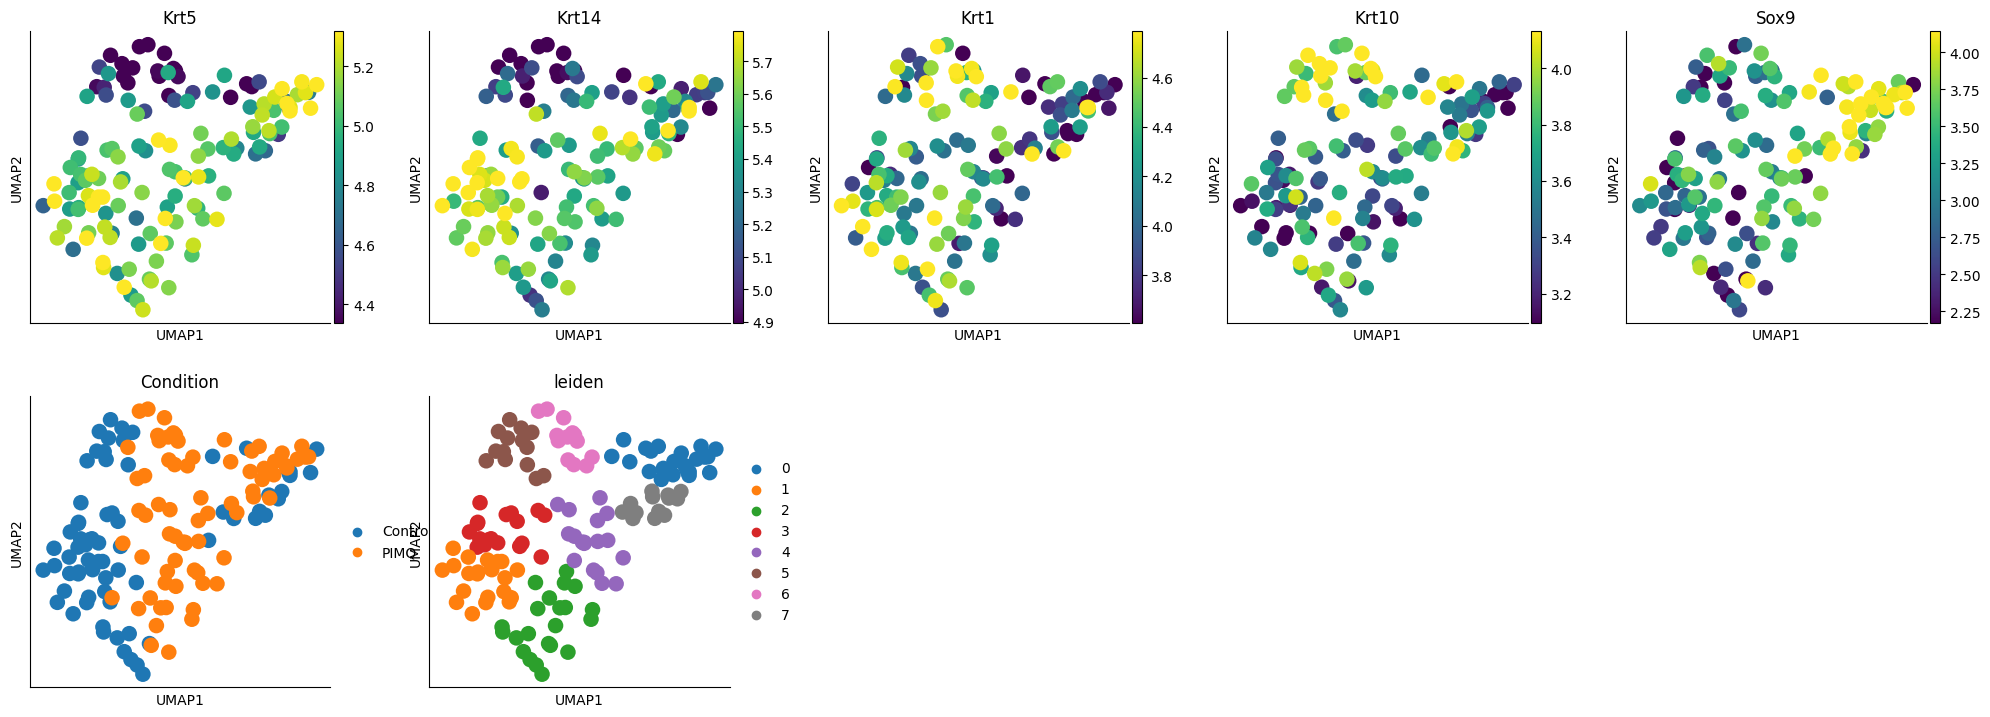

In [ ]:
# Merge and preprocess metacell data
ad_meta = sc.concat([ctrl_meta_ad, pimq_meta_ad])
ad_meta.obs['n_counts'] = np.ravel(ad_meta.X.sum(axis=1))

# Filter and normalize peak accessibility matrix
sc.pp.filter_genes(ad_meta, min_cells=1)
sc.pp.normalize_total(ad_meta, key_added='n_counts')
sc.pp.log1p(ad_meta)

# Filter and normalize gene activity scores
ad_genescores = anndata.AnnData(ad_meta.obsm['GeneScores'])
sc.pp.filter_genes(ad_genescores, min_cells=1)
sc.pp.normalize_total(ad_genescores)
sc.pp.log1p(ad_genescores)
ad_meta.obsm['GeneScores'] = ad_genescores.to_df()

# Compute neighborhood graph on UMAP coordinates (preserve original structure)
sc.pp.neighbors(ad_meta, use_rep='X_umap')

# Add condition labels
metacell_ids = list(ad_meta.obs.index)
conditions = ['Control' if mid.endswith('-0') else 'PIMQ' for mid in metacell_ids]
ad_meta.obs['Condition'] = conditions

# Compute Leiden clustering
sc.tl.leiden(ad_meta, resolution=1)

# Add gene scores to obs for visualization
genes_of_interest = ['Krt5', 'Krt14', 'Krt1', 'Krt10', 'Sox9']
for gene in genes_of_interest:
    if gene not in ad_meta.obs:
        try:
            ad_meta.obs[gene] = ad_meta.obsm['GeneScores'][gene]
        except:
            ad_meta.obs[gene] = 0

# Visualize metacells by gene scores and conditions
sc.pl.umap(ad_meta, color=genes_of_interest + ['Condition', 'leiden'], ncols=5, 
           vmin='p10', vmax='p90', s=500, color_map='viridis')

In [ ]:
# Annotate metacells with cell type labels based on Leiden clusters
ad_meta.obs['celltype'] = None

# Undifferentiated basal (UB) - expressing high Krt14/Krt5
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['1', '2', '3', '4']), 'celltype'] = 'UB'

# Differentiating basal (DB) - transitional state
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['6', '5']), 'celltype'] = 'DB'

# Upper hair follicle (uHF) - Krt1/Krt10 positive
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['0', '7']), 'celltype'] = 'uHF'


In [ ]:
# Create combined condition-celltype labels for differential analysis
ad_meta.obs['condition_celltype'] = ad_meta.obs['Condition'].astype(str) + '_' + ad_meta.obs['celltype'].astype(str)

In [ ]:
# Create output folder for differential analysis input files
output_folder = '../intermediate_outputs3/DESeq2_files/'
os.makedirs(output_folder, exist_ok=True)

# Export metadata for DESeq2 analysis
ad_meta.obs.to_csv('../intermediate_outputs3/DESeq2_files/metadata_scpeakset_D30.tsv', sep='\t')

In [ ]:
# Export metacell metadata with UMAP coordinates
ad_meta.obs.to_excel(input_dir + 'seacells/' + 'SEACell_metadata_UMAP.xlsx')

In [ ]:
# Create output directory and save processed metacell data
output_folder = '../intermediate_outputs3/sc_data/'
os.makedirs(output_folder, exist_ok=True)

import pickle
with open('../intermediate_outputs3/sc_data/D30_scpeakset.pickle', 'wb') as f:
    pickle.dump(ad_meta, f)

# Y1 Dataset: SEACells Metacell Construction

In [ ]:
# Define paths for Y1 dataset
timepoint = 'Y1'
sample_type = 'Y1'

input_dir = '../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/'
data_dir = input_dir + 'seacells/SEACells_export/'


In [ ]:
# Load peak count data from sparse matrix format
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

# Load cell and peak metadata
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)

# Create peak identifiers in format: chr:start-end
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)

In [ ]:
# Create AnnData object from peak count matrix
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index

# Add peak annotations to variable metadata
for col in peaks.columns:
    ad.var[col] = peaks[col]
    
# Convert to CSR format for efficient computation
ad.X = ad.X.tocsr()

# Load LSI dimensionality reduction coordinates
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

# Load and integrate cell metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

# Load gene activity scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

In [37]:
ad

AnnData object with n_obs × n_vars = 4476 × 164945
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'DoubletScore', 'DoubletEnrichment', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'
    uns: 'GeneScoresColums'
    obsm: 'X_svd', 'GeneScores'

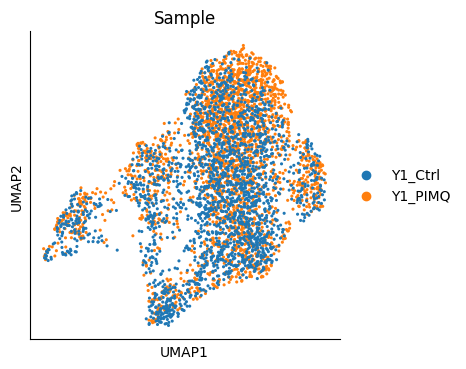

In [ ]:
# Compute neighbors, UMAP, and clustering
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)

# Visualize samples in UMAP space
sc.pl.umap(ad, color=['Sample'], vmin='p5', vmax='p95', s=20)

In [ ]:
# Split data by experimental condition
ad_ctrl = ad[ad.obs['Sample'] == sample_type + '_Ctrl']
ad_pimq = ad[ad.obs['Sample'] == sample_type + '_PIMQ']

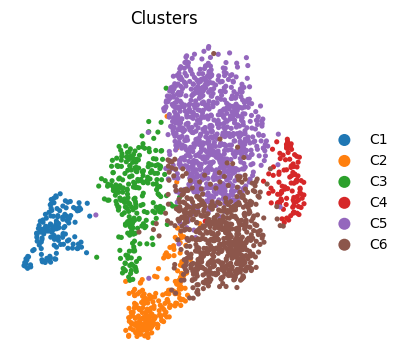

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2182 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2182 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2182 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 26 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 13/13 [00:00<00:00, 505.30it/s]

Selecting 3 cells from greedy initialization.


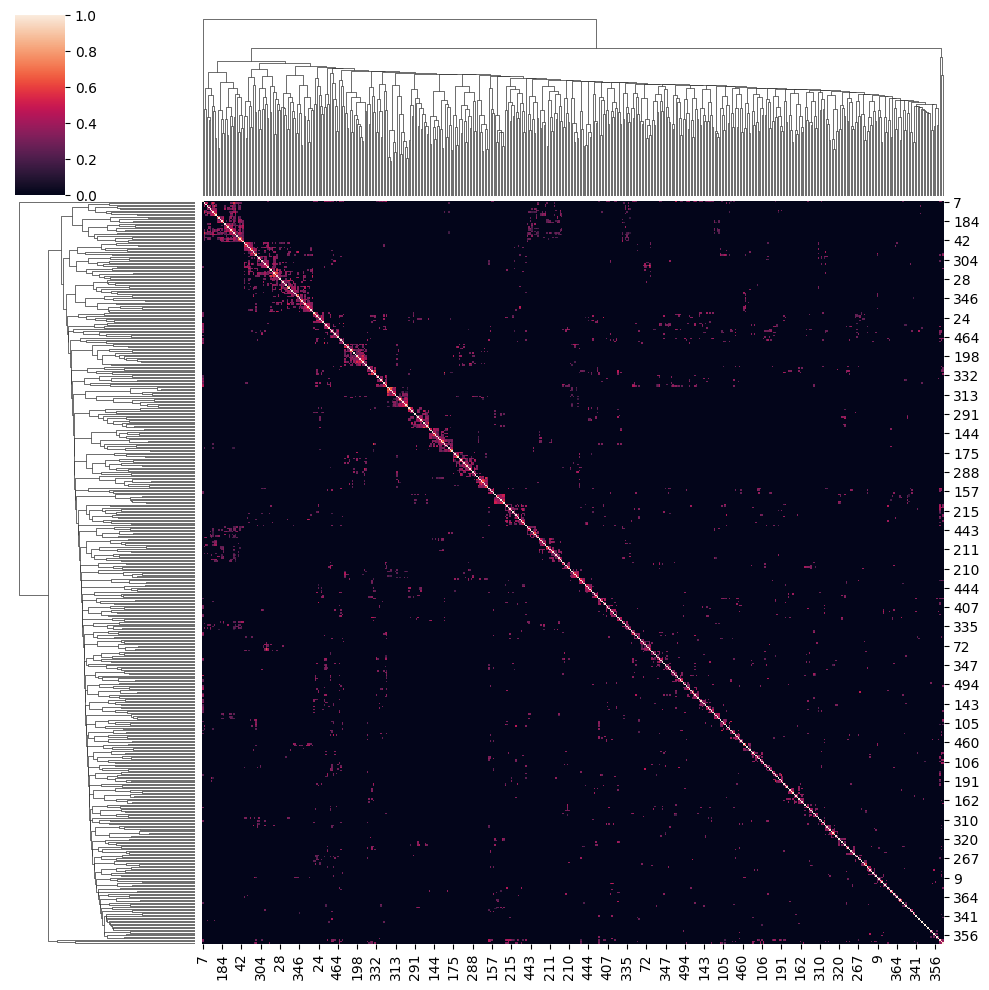

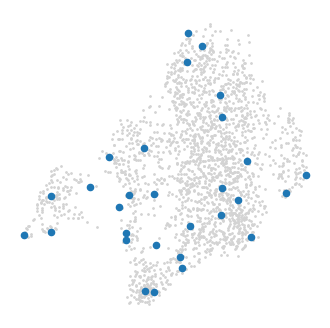

Randomly initialized A matrix.
Setting convergence threshold at 0.00083
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.


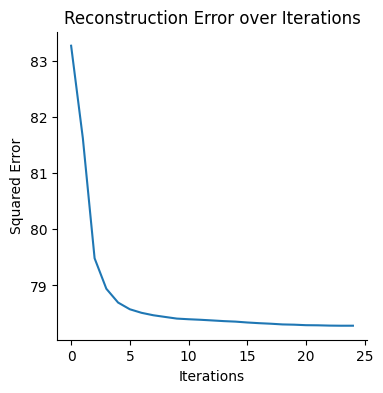

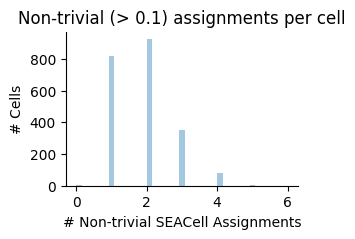

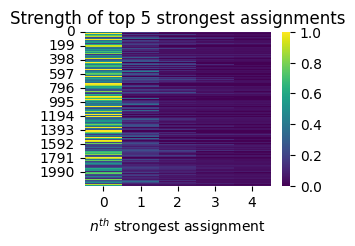

100%|██████████| 29/29 [00:40<00:00,  1.40s/it]


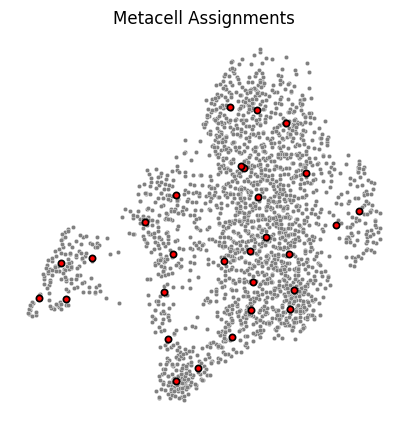

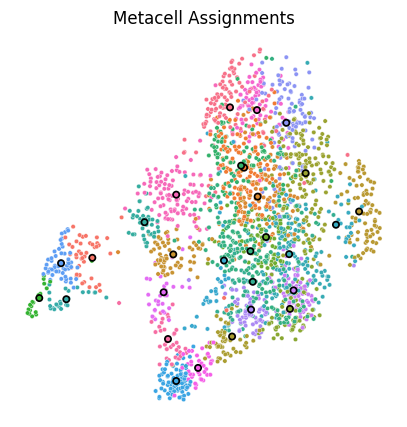

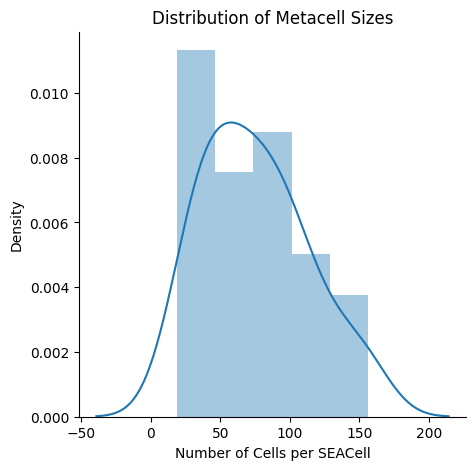

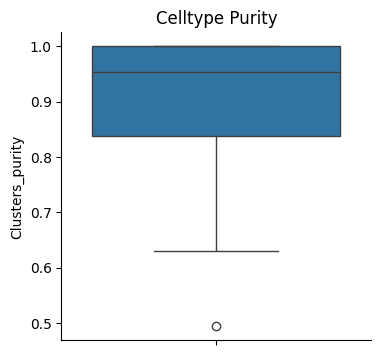

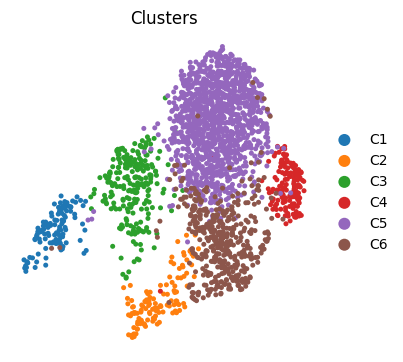

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2294 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2294 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2294 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 27 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 13/13 [00:00<00:00, 456.12it/s]

Selecting 3 cells from greedy initialization.


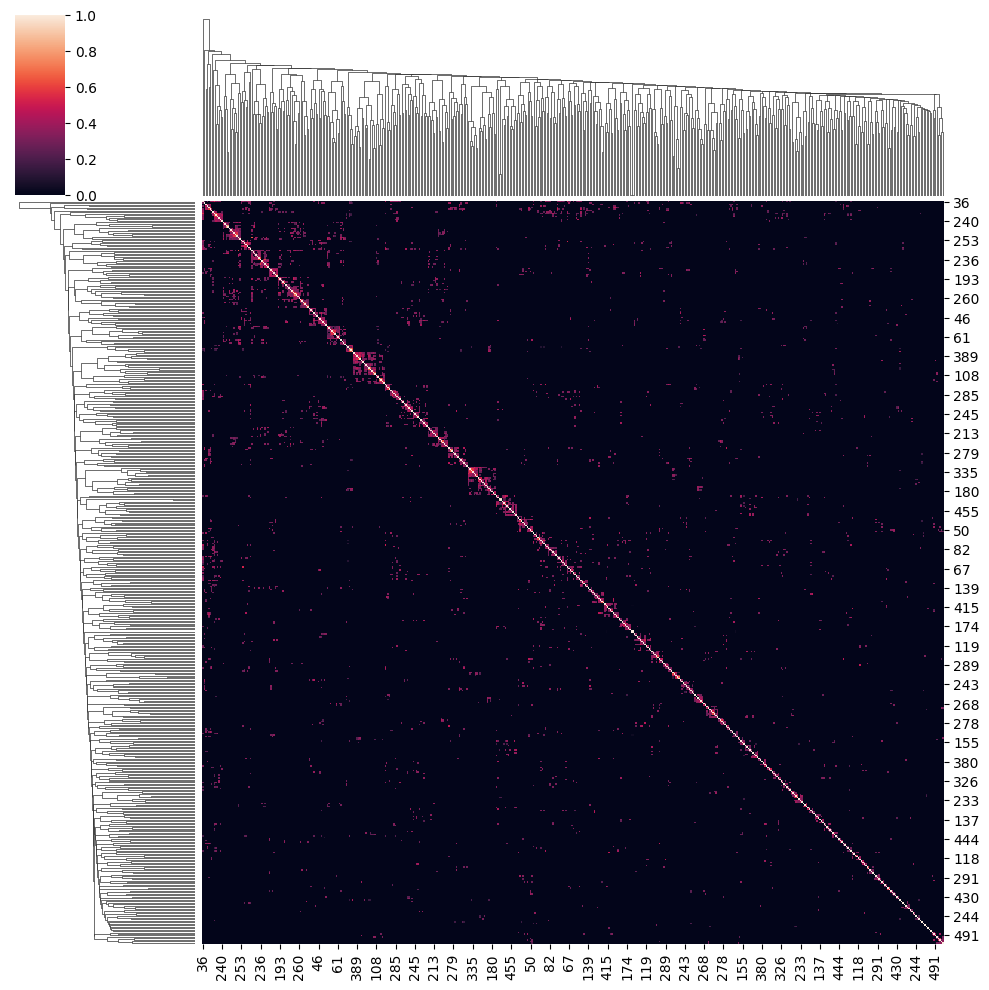

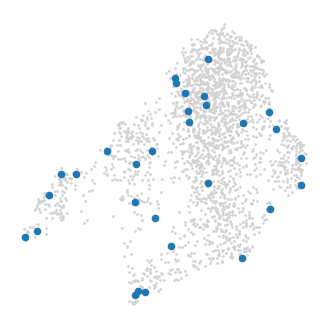

Randomly initialized A matrix.
Setting convergence threshold at 0.00086
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 25 iterations.


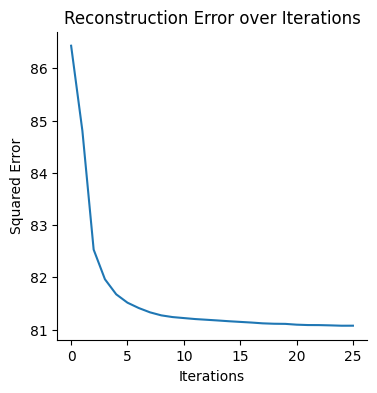

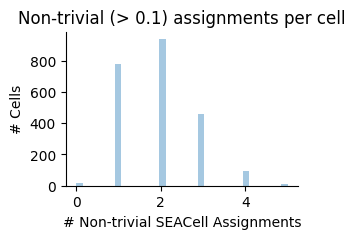

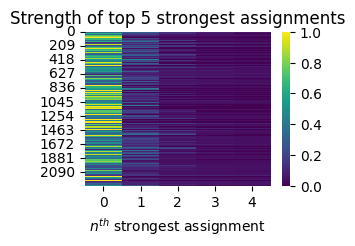

100%|██████████| 30/30 [00:42<00:00,  1.41s/it]


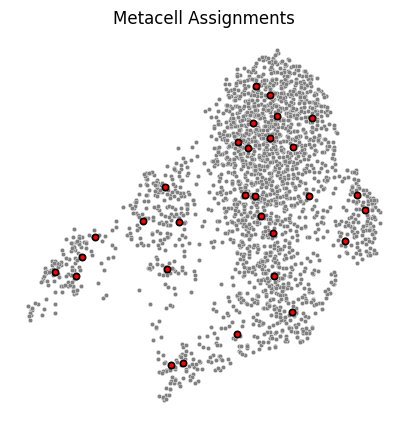

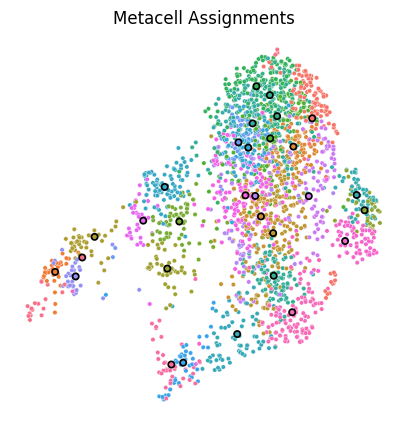

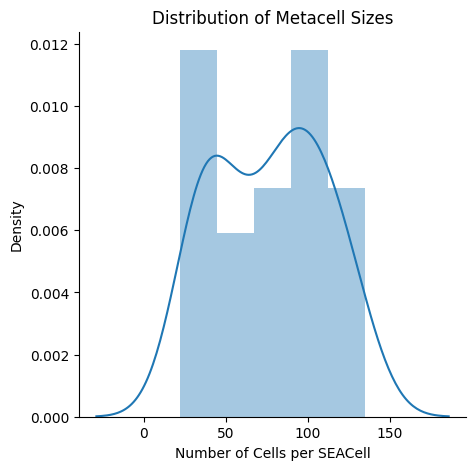

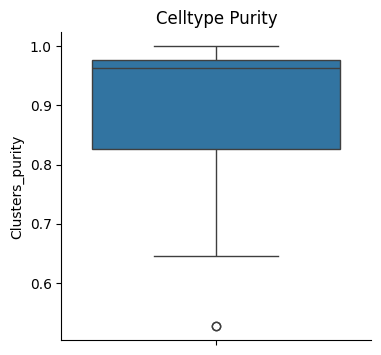

In [ ]:
# Compute SEACells metacells for Control and PIMQ conditions
results_ctrl = compute_SEACells(ad=ad_ctrl, max_iter=500)
results_pimq = compute_SEACells(ad=ad_pimq, max_iter=500)

In [ ]:
# Add unique identifiers to SEACell labels to distinguish conditions
results_ctrl[0].obs['SEACell'] = results_ctrl[0].obs['SEACell'] + '-0'
results_pimq[0].obs['SEACell'] = results_pimq[0].obs['SEACell'] + '-1'

# Save individual SEACell results
results_ctrl[0].write(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
results_pimq[0].write(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')

# Store results in list for downstream processing
res_list = [results_ctrl, results_pimq]

# Reload SEACell assignments
ad_ctrl = sc.read(input_dir + 'seacells/' + timepoint + '_Control.h5ad')
ad_pimq = sc.read(input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad')

# Export SEACell assignments to Excel
ad_ctrl.obs['SEACell'].to_frame().to_excel(input_dir + 'seacells/' + 'SEACell_control.xlsx')
ad_pimq.obs['SEACell'].to_frame().to_excel(input_dir + 'seacells/' + 'SEACell_PIMQ.xlsx')

# Create combined dataset list
ad_list = [ad_ctrl, ad_pimq]
    
# Calculate total fragment counts per SEACell
nFrags = pd.concat([ad_list[0].obs.groupby(by='SEACell')['nFrags'].sum(),
                   ad_list[1].obs.groupby(by='SEACell')['nFrags'].sum()])
nFrags.to_csv(input_dir + 'seacells/' + 'nFrags_per_seacell.csv')

# Merge Control and PIMQ datasets
ads_merged = anndata.concat([ad_list[0], ad_list[1]], label='batch')
ads_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_ad_concat.h5ad')

# Process SEACell hard assignments (discrete metacell assignments)
hard_list = []
for i in range(2):
    i_str = '-' + str(i)
    res_list[i][1].obs = res_list[i][1].obs.rename(index=lambda x: x + i_str)
    hard_list.append(res_list[i][1])
    
SEACells_hard_merged = anndata.concat([hard_list[0], hard_list[1]], label='batch')
SEACells_hard_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_SEACells_hard_concat.h5ad')

# Process SEACell soft assignments (probabilistic cluster membership)
soft_cluster_list = []
for i in range(2):
    i_str = '-' + str(i)
    res_list[i][2].obs = res_list[i][2].obs.rename(index=lambda x: 'SEACell-' + x + i_str)
    soft_cluster_list.append(res_list[i][2])
    
SEACells_soft_cluster_merged = anndata.concat([soft_cluster_list[0], soft_cluster_list[1]], label='batch')
SEACells_soft_cluster_merged.write(input_dir + 'seacells/' + timepoint + '_EpdSCs_SEACells_soft_concat.h5ad')

In [ ]:
# Set random seed for reproducibility
np.random.seed(1966)

# Define input directory and timepoint for Year 1 dataset
input_dir = '../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/'
timepoint = 'Y1'
sample_type = 'Y1'

print(input_dir)

# Specify paths to Control and PIMQ SEACell data
control_path = input_dir + 'seacells/' + timepoint + '_Control.h5ad'
pimq_path = input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad'

print(control_path)
print(pimq_path)

../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/
../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/seacells/Y1_Control.h5ad
../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/seacells/Y1_PIMQ.h5ad


In [ ]:
# Load Control SEACell data
control_ad = sc.read(control_path)
SEACells_label = "SEACell"

# Identify valid metacells (with more than 1 cell)
metacells = control_ad.obs[SEACells_label].astype(str).unique()
metacells = metacells[control_ad.obs[SEACells_label].value_counts()[metacells] > 1]

print("Generating metacell matrices...")
print("ATAC")
    
# Aggregate cells into metacells by summing ATAC counts
control_meta_ad = SEACells.core.summarize_by_SEACell(control_ad, SEACells_label=SEACells_label, summarize_layer="X")
print(control_meta_ad)

# Reorder SEACells for consistent indexing
control_meta_ad = control_meta_ad[['SEACell-' + str(i) + '-0' for i in range(control_meta_ad.shape[0])], :]

# Summarize SVD coordinates for metacells
svd = pd.DataFrame(control_ad.obsm["X_svd"], index=control_ad.obs_names)

Generating Metacell matrices...
ATAC


100%|██████████| 29/29 [00:01<00:00, 19.13it/s]


AnnData object with n_obs × n_vars = 29 × 164945
    layers: 'raw'


In [ ]:
# Load and process Control and PIMQ metacell data
control_meta_ad, pimq_meta_ad = read_input_ad_normalization_later(control_path, pimq_path)

Generating Metacell matrices...
ATAC


100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


AnnData object with n_obs × n_vars = 29 × 164945
    layers: 'raw'
Generating Metacell matrices...
ATAC


100%|██████████| 30/30 [00:01<00:00, 19.28it/s]


AnnData object with n_obs × n_vars = 30 × 164945
    layers: 'raw'


In [ ]:
# Merge Control and PIMQ metacell datasets
ad_meta = sc.concat([control_meta_ad, pimq_meta_ad])

# Calculate total counts per metacell
ad_meta.obs['n_counts'] = np.ravel(ad_meta.X.sum(axis=1))

# Filter and normalize peak matrix
sc.pp.filter_genes(ad_meta, min_cells=1)
sc.pp.normalize_total(ad_meta, key_added='n_counts')
sc.pp.log1p(ad_meta)

# Create and process gene score matrix
ad_genescores = anndata.AnnData(ad_meta.obsm['GeneScores'])
sc.pp.filter_genes(ad_genescores, min_cells=1)
sc.pp.normalize_total(ad_genescores)
sc.pp.log1p(ad_genescores)

# Update gene scores in main object
ad_meta.obsm['GeneScores'] = ad_genescores.to_df()

# Compute UMAP embedding from LSI coordinates
sc.pp.neighbors(ad_meta, use_rep='X_svd', n_neighbors=3)

# Add Condition labels based on metacell identifier suffix
ids = list(ad_meta.obs.index)
Condition = []
for id in ids:
    if id.endswith('-0'):
        Condition.append('Control')
    else:
        Condition.append('PIMQ')
ad_meta.obs['Condition'] = Condition

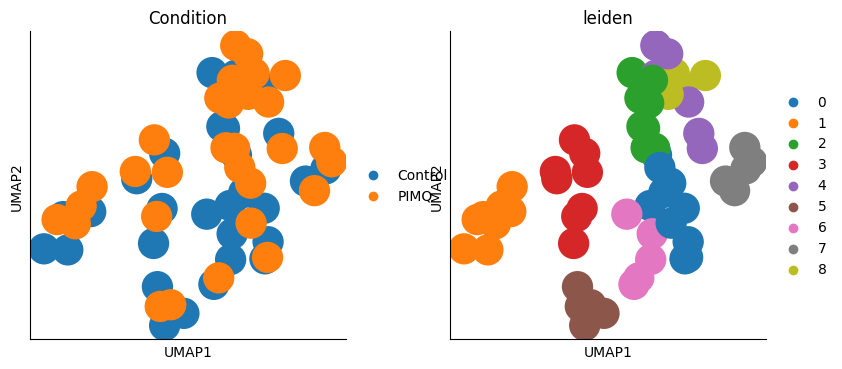

In [ ]:
# Perform Leiden clustering and visualize by condition
sc.tl.leiden(ad_meta)
sc.pl.umap(ad_meta, color=['Condition', 'leiden'])

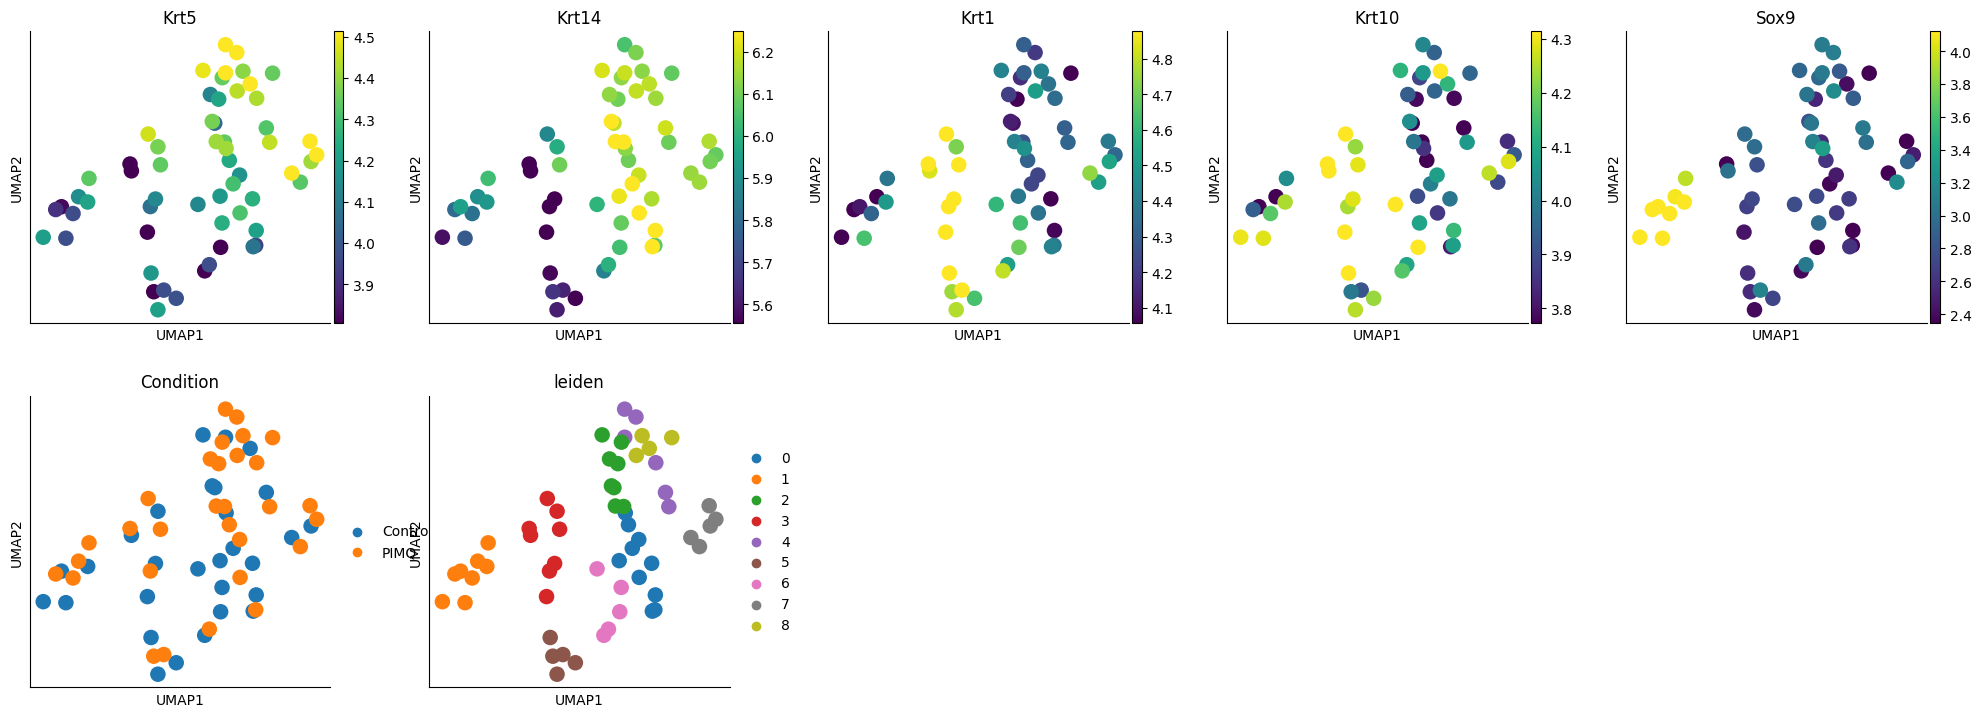

In [ ]:
# Add gene scores for key epidermal markers to observation metadata
genes_of_interest = ['Krt5', 'Krt14', 'Krt1', 'Krt10', 'Sox9']
for gene in genes_of_interest:
    if gene not in ad_meta.obs:
        try:
            ad_meta.obs[gene] = ad_meta.obsm['GeneScores'][gene]
        except:
            ad_meta.obs[gene] = 0

# Visualize marker expression and clustering
sc.pl.umap(ad_meta, color=genes_of_interest + ['Condition', 'leiden'], ncols=5, vmin='p10', vmax='p90', s=500, cmap='viridis')

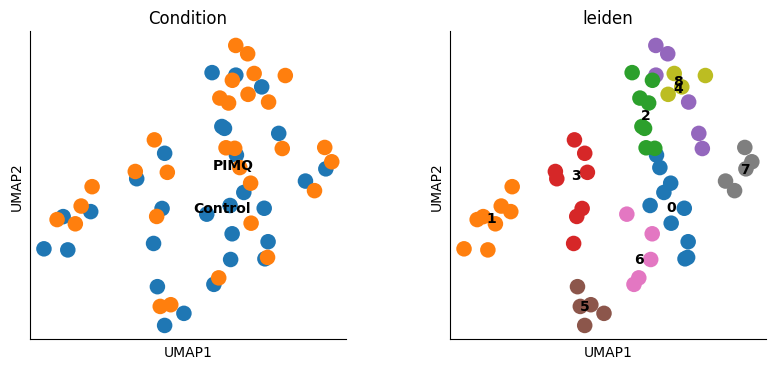

In [ ]:
# Display UMAP with cluster labels overlaid on data points
sc.pl.umap(ad_meta, color=['Condition', 'leiden'], ncols=5, vmin='p10', vmax='p90', s=500, legend_loc='on data')

In [ ]:
# Assign cell types based on Leiden clustering
ad_meta.obs['celltype'] = None
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['0', '2', '4', '6', '7', '8']), 'celltype'] = 'UB'  # Undifferentiated basal
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['3', '5']), 'celltype'] = 'DB'  # Differentiating basal
ad_meta.obs.loc[ad_meta.obs['leiden'].isin(['1']), 'celltype'] = 'uHF'  # Upper hair follicle

# Create combined condition-celltype labels
ad_meta.obs['condition_celltype'] = ad_meta.obs['Condition'].astype(str) + '_' + ad_meta.obs['celltype'].astype(str)

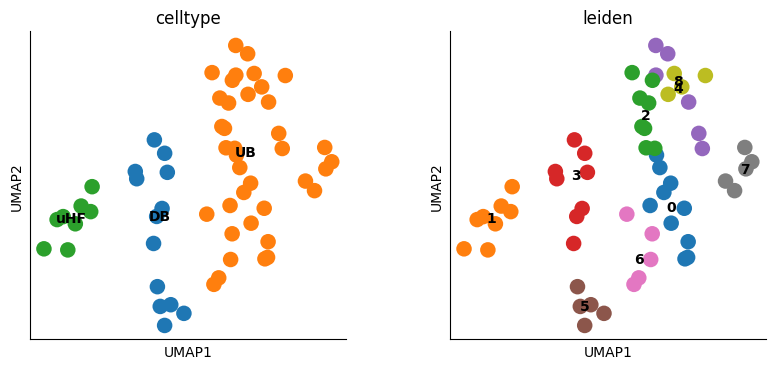

In [ ]:
# Visualize cell type assignments
sc.pl.umap(ad_meta, color=['celltype', 'leiden'], ncols=5, vmin='p10', vmax='p90', s=500, legend_loc='on data')

In [ ]:
# Export metacell metadata with UMAP coordinates and annotations
ad_meta.obs.to_excel(input_dir + 'seacells/' + 'SEACell_metadata_UMAP.xlsx')

In [ ]:
# Save processed metacell data as pickle file
import pickle
with open('../intermediate_outputs3/sc_data/Y1_scpeakset.pickle', 'wb') as o1:
    pickle.dump(ad_meta, o1)

In [ ]:
# Export metadata for DESeq2 differential accessibility analysis
ad_meta.obs.to_csv('../intermediate_outputs3/DESeq2_files/metadata_scpeakset_Y1.tsv', sep='\t')

# Get stats of SEACells #

In [ ]:
# Set random seed for reproducibility
np.random.seed(1966)

# Define paths for Year 1 dataset
input_dir = '../intermediate_outputs3/projects/ArchR_Y1_min_NA_max_600_scpeakset/'
timepoint = 'Y1'
sample_type = 'Y1'

print(input_dir)

# Specify Control and PIMQ SEACell file paths
control_path = input_dir + 'seacells/' + timepoint + '_Control.h5ad'
pimq_path = input_dir + 'seacells/' + timepoint + '_PIMQ.h5ad'

print(control_path)
print(pimq_path)

../intermediate_outputs2/projects/ArchR_Y1_min_NA_max_600_scpeakset/
../intermediate_outputs2/projects/ArchR_Y1_min_NA_max_600_scpeakset/seacells/Y1_Control.h5ad
../intermediate_outputs2/projects/ArchR_Y1_min_NA_max_600_scpeakset/seacells/Y1_PIMQ.h5ad


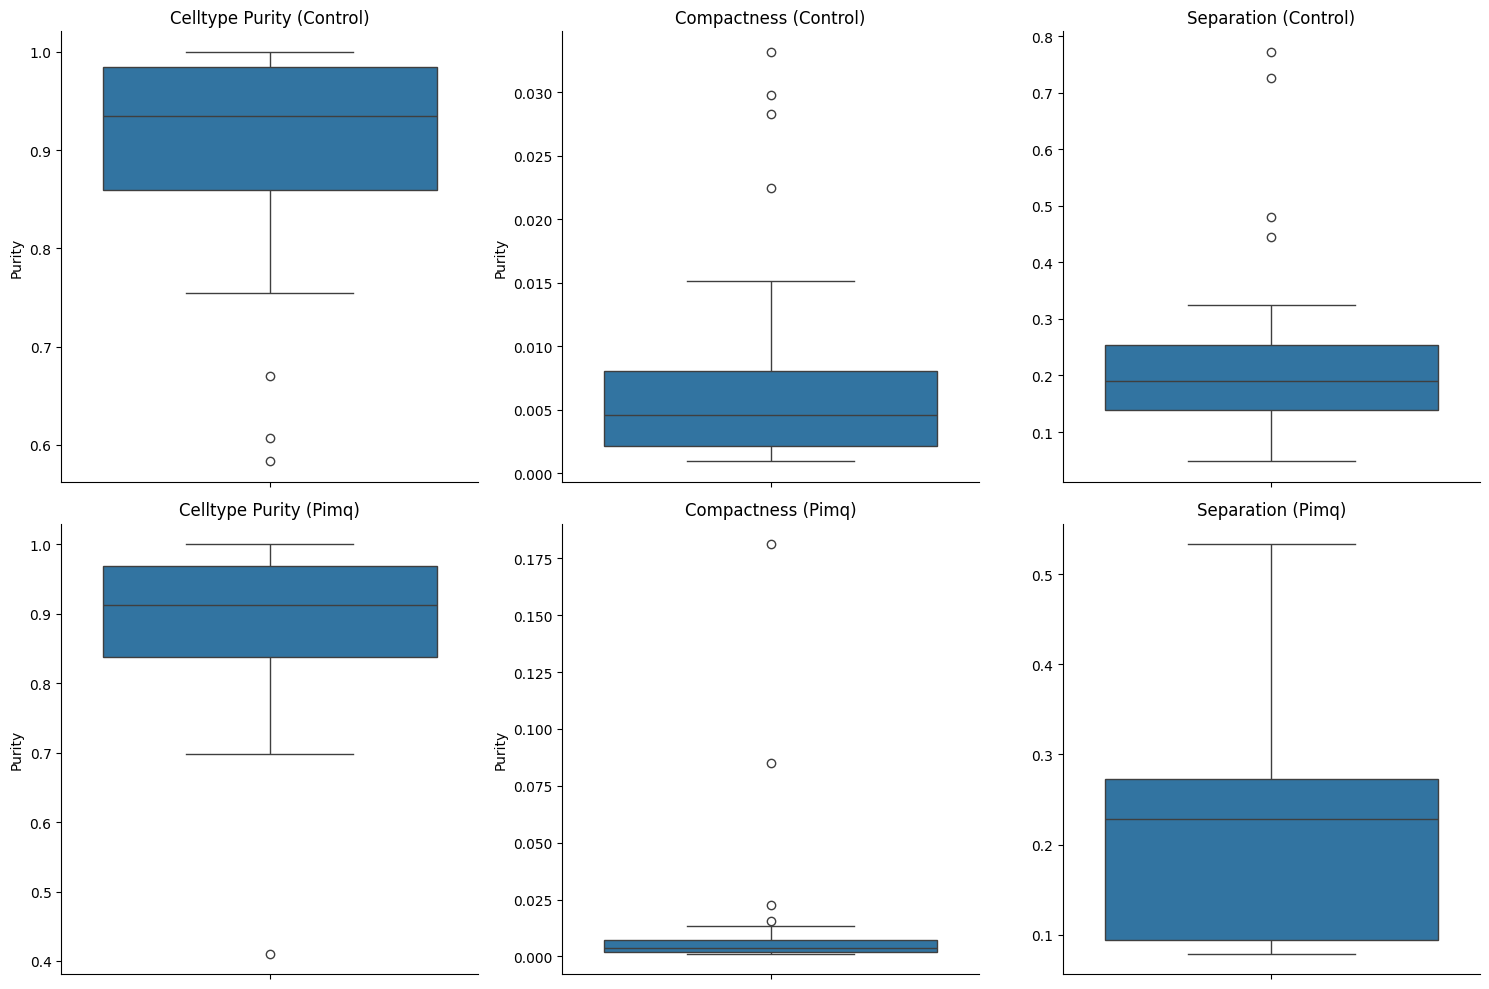

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load Control and PIMQ SEACell datasets
ad_ctrl = sc.read(control_path)
ad_pimq = sc.read(pimq_path)

# Compute quality metrics for Control condition
SEACell_purity_ctrl = SEACells.evaluate.compute_celltype_purity(ad_ctrl, 'Clusters')
compactness_ctrl = SEACells.evaluate.compactness(ad_ctrl, 'X_svd')
separation_ctrl = SEACells.evaluate.separation(ad_ctrl, 'X_svd', nth_nbr=1)

# Compute quality metrics for PIMQ condition
SEACell_purity_pimq = SEACells.evaluate.compute_celltype_purity(ad_pimq, 'Clusters')
compactness_pimq = SEACells.evaluate.compactness(ad_pimq, 'X_svd')
separation_pimq = SEACells.evaluate.separation(ad_pimq, 'X_svd', nth_nbr=1)

# Create comparison figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot metrics for Control condition (top row)
sns.boxplot(data=SEACell_purity_ctrl, y='Clusters_purity', ax=axes[0, 0])
axes[0, 0].set_title('Celltype Purity (Control)')
axes[0, 0].set_ylabel('Purity')

sns.boxplot(data=compactness_ctrl, y='compactness', ax=axes[0, 1])
axes[0, 1].set_title('Compactness (Control)')
axes[0, 1].set_ylabel('Purity')

sns.boxplot(data=separation_ctrl, y='separation', ax=axes[0, 2])
axes[0, 2].set_title('Separation (Control)')
axes[0, 2].set_ylabel('')

# Plot metrics for PIMQ condition (bottom row)
sns.boxplot(data=SEACell_purity_pimq, y='Clusters_purity', ax=axes[1, 0])
axes[1, 0].set_title('Celltype Purity (PIMQ)')
axes[1, 0].set_ylabel('Purity')

sns.boxplot(data=compactness_pimq, y='compactness', ax=axes[1, 1])
axes[1, 1].set_title('Compactness (PIMQ)')
axes[1, 1].set_ylabel('Purity')

sns.boxplot(data=separation_pimq, y='separation', ax=axes[1, 2])
axes[1, 2].set_title('Separation (PIMQ)')
axes[1, 2].set_ylabel('')

# Adjust layout and display
plt.tight_layout()
sns.despine()
plt.show()